In [394]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.colors import rgb2hex, LogNorm
from matplotlib.patches import Polygon
from matplotlib.colorbar import ColorbarBase

from matplotlib.colors import LogNorm
import pylab
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 9.0)

Populating the interactive namespace from numpy and matplotlib


/Users/ekpease/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['ylim', 'poly', 'pylab', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## I'm going to try to use US Energy Information Agency (EIA) data to rank utility companies in the US and in individual states. Let's find out what the most (and least) reliable utility company was in 2016.

In [395]:
# Electric power sales, revenue, and energy efficiency Form EIA-861 detailed data files 
# https://www.eia.gov/electricity/data/eia861/ (Accessed April 6, 2018)
# Data from 2016 (for this example)

# Load in Reliability data from excel document
# Only considering RESIDENTIAL data in this notebook at present
test = pd.read_excel('/Users/ekpease/Data/f8612016/Reliability_2016.xlsx',header=1,skip_footer=1,\
                     usecols=np.arange(14))

# Replace non-numeric elements with numbers
test['Number of Customers'] = test['Number of Customers'].replace('.',0)
test['SAIDI With MED'] = test['SAIDI With MED'].replace('.',-99)
test['SAIFI With MED'] = test['SAIFI With MED'].replace('.',-99)
test['SAIDI Without MED'] = test['SAIDI Without MED'].replace('.',-99)
test['SAIFI Without MED'] = test['SAIFI Without MED'].replace('.',-99)

In [396]:
utilities_basicinfo = test.as_matrix(columns=['State','Number of Customers','Ownership','SAIDI With MED','SAIFI With MED','SAIDI Without MED','SAIFI Without MED','Utility Name'])
short_state_names = {
        'AK': 'Alaska',
        'AL': 'Alabama',
        'AR': 'Arkansas',
        'AS': 'American Samoa',
        'AZ': 'Arizona',
        'CA': 'California',
        'CO': 'Colorado',
        'CT': 'Connecticut',
        'DC': 'District of Columbia',
        'DE': 'Delaware',
        'FL': 'Florida',
        'GA': 'Georgia',
        'GU': 'Guam',
        'HI': 'Hawaii',
        'IA': 'Iowa',
        'ID': 'Idaho',
        'IL': 'Illinois',
        'IN': 'Indiana',
        'KS': 'Kansas',
        'KY': 'Kentucky',
        'LA': 'Louisiana',
        'MA': 'Massachusetts',
        'MD': 'Maryland',
        'ME': 'Maine',
        'MI': 'Michigan',
        'MN': 'Minnesota',
        'MO': 'Missouri',
        'MP': 'Northern Mariana Islands',
        'MS': 'Mississippi',
        'MT': 'Montana',
        'NA': 'National',
        'NC': 'North Carolina',
        'ND': 'North Dakota',
        'NE': 'Nebraska',
        'NH': 'New Hampshire',
        'NJ': 'New Jersey',
        'NM': 'New Mexico',
        'NV': 'Nevada',
        'NY': 'New York',
        'OH': 'Ohio',
        'OK': 'Oklahoma',
        'OR': 'Oregon',
        'PA': 'Pennsylvania',
        'PR': 'Puerto Rico',
        'RI': 'Rhode Island',
        'SC': 'South Carolina',
        'SD': 'South Dakota',
        'TN': 'Tennessee',
        'TX': 'Texas',
        'UT': 'Utah',
        'VA': 'Virginia',
        'VI': 'Virgin Islands',
        'VT': 'Vermont',
        'WA': 'Washington',
        'WI': 'Wisconsin',
        'WV': 'West Virginia',
        'WY': 'Wyoming'
}


# Households by state, 2009-2013
# https://www.indexmundi.com/facts/united-states/quick-facts/all-states/households

households = {
        'Alabama': 1838683,
        'Alaska': 251899,
        'Arizona': 2370289,
        'Arkansas': 1129723,
        'California': 12542460,
        'Colorado': 1977591,
        'Connecticut': 1355849,
        'Delaware': 335707,
        'District of Columbia': 263649,
        'Florida': 7158980,
        'Georgia': 3518097,
        'Hawaii': 449771,
        'Idaho': 579797,
        'Illinois': 4772723,
        'Indiana': 2481793,
        'Iowa': 1226547,
        'Kansas': 1110440,
        'Kentucky': 1694996,
        'Louisiana': 1707852,
        'Maine': 553823,
        'Maryland': 2146240,
        'Massachusetts': 2530147,
        'Michigan': 3823280,
        'Minnesota': 2107232,
        'Mississippi': 1088073,
        'Missouri': 2360131,
        'Montana': 405525,
        'Nebraska': 725787,
        'Nevada': 999016,
        'New Hampshire': 518245,
        'New Jersey': 3186418,
        'New Mexico': 761938,
        'New York': 7234743,
        'North Carolina': 3715565,
        'North Dakota': 287270,
        'Ohio': 4557655,
        'Oklahoma': 1444081,
        'Oregon': 1516456,
        'Pennsylvania': 4958427,
        'Rhode Island': 410058,
        'South Carolina': 1780251,
        'South Dakota': 323136,
        'Tennessee': 2475195,
        'Texas': 8886471,
        'Utah': 886770,
        'Vermont': 257004,
        'Virginia': 3022739,
        'Washington': 2629126,
        'West Virginia': 741390,
        'Wisconsin': 2288332,
        'Wyoming': 222846
}

In [397]:
# Keep data in numpy dictionaries

# loop through short names
# for each name, write two elements: 0==long name, 1==sum(number of customers with state name==short name)
utilkeys = ['State','Customers','Type','SAIDI','SAIFI','SAIDI_noMED','SAIFI_noMED','Name']
utilDict = dict()
for ii in range(8):
    utilDict[utilkeys[ii]]=utilities_basicinfo[:,ii][(utilities_basicinfo[:,1]>0)]
for ii in range(len(utilDict['State'])):
    utilDict['State'][ii] = short_state_names[utilDict['State'][ii]]
for item in utilDict.keys():
    utilDict[item] = np.asarray(utilDict[item])
    
statekeys = ['State','TotalCustomers','Households','avgSAIDI','avgSAIFI','avgSAIDI_noMED','avgSAIFI_noMED']
stateDict = {key: [] for key in statekeys}
for stateXX in np.unique(utilities_basicinfo[:,0]):
    stateDict['State'].append(short_state_names[stateXX])
    stateDict['TotalCustomers'].append(sum(utilities_basicinfo[:,1][utilities_basicinfo[:,0]==stateXX]))
    stateDict['Households'].append(households[short_state_names[stateXX]])
    stateDict['avgSAIDI'].append(sum((utilDict['Customers']*utilDict['SAIDI'])[(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIDI']>=0)])/sum(utilDict['Customers'][(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIDI']>=0)]))
    stateDict['avgSAIFI'].append(sum((utilDict['Customers']*utilDict['SAIFI'])[(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIFI']>=0)])/sum(utilDict['Customers'][(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIFI']>=0)]))
    stateDict['avgSAIDI_noMED'].append(sum((utilDict['Customers']*utilDict['SAIDI_noMED'])[(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIDI_noMED']>=0)])/sum(utilDict['Customers'][(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIDI_noMED']>=0)]))
    stateDict['avgSAIFI_noMED'].append(sum((utilDict['Customers']*utilDict['SAIFI_noMED'])[(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIFI_noMED']>=0)])/sum(utilDict['Customers'][(utilDict['State']==short_state_names[stateXX]) & (utilDict['SAIFI_noMED']>=0)]))
for item in stateDict.keys():
    stateDict[item] = np.asarray(stateDict[item])

# Let's get started. How many customers are included in this dataset?

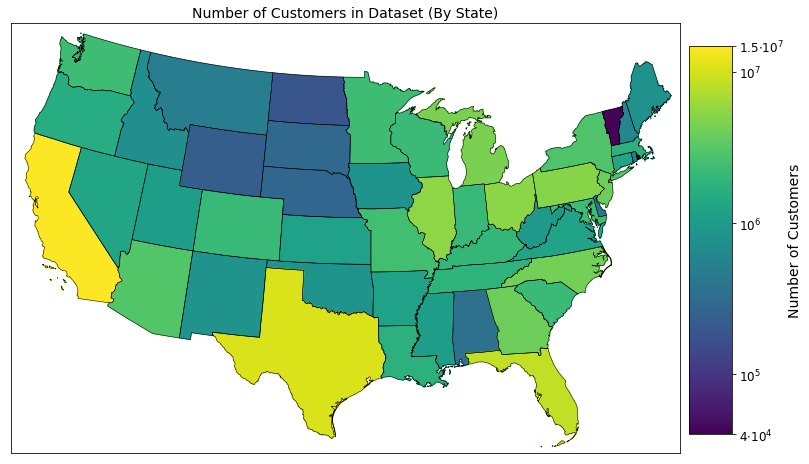

In [398]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.readshapefile('/Users/ekpease/Downloads/cb_2017_us_state_5m/cb_2017_us_state_5m', name='states', drawbounds=True)

cmap = plt.cm.viridis
statenames = []
stateDict['map_color_tot'] = np.zeros([len(stateDict['State']),4])
stateDict['map_color_frac'] = np.zeros([len(stateDict['State']),4])
stateDict['map_color_SAIDI'] = np.zeros([len(stateDict['State']),4])
stateDict['map_color_SAIFI'] = np.zeros([len(stateDict['State']),4])
stateDict['map_color_SAIDI_noMED'] = np.zeros([len(stateDict['State']),4])
stateDict['map_color_SAIFI_noMED'] = np.zeros([len(stateDict['State']),4])
max_log10 = np.log10(15000000)
min_log10 = np.log10(40000)
for shapedict in m.states_info:
    statename = shapedict['NAME']
    if statename in stateDict['State']:
        stateDict['map_color_tot'][stateDict['State']==statename] = cmap((np.log10(stateDict['TotalCustomers'][stateDict['State']==statename])-min_log10)/(max_log10-min_log10))[:3]
        stateDict['map_color_frac'][stateDict['State']==statename] = cmap(stateDict['TotalCustomers'][stateDict['State']==statename]/(1.5*stateDict['Households'][stateDict['State']==statename]))[:3]
        stateDict['map_color_SAIDI'][stateDict['State']==statename] = cmap(stateDict['avgSAIDI'][stateDict['State']==statename]/1000)[:3]
        stateDict['map_color_SAIFI'][stateDict['State']==statename] = cmap(stateDict['avgSAIFI'][stateDict['State']==statename]/max(stateDict['avgSAIFI']))[:3]
        stateDict['map_color_SAIDI_noMED'][stateDict['State']==statename] = cmap(stateDict['avgSAIDI_noMED'][stateDict['State']==statename]/360)[:3]
        stateDict['map_color_SAIFI_noMED'][stateDict['State']==statename] = cmap(stateDict['avgSAIFI_noMED'][stateDict['State']==statename]/max(stateDict['avgSAIFI_noMED']))[:3]
    statenames.append(statename)

ax = plt.gca() # get current axes instance
fig = plt.gcf()    
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] in stateDict['State']:
        color = rgb2hex(stateDict['map_color_tot'][stateDict['State']==statenames[nshape]].ravel()) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.title('Number of Customers in Dataset (By State)',fontsize=14)
cax = fig.add_axes([0.91, 0.2, 0.05, 0.6]) # posititon
cb = ColorbarBase(cax,cmap=cmap,orientation='vertical')
cb.set_label('Number of Customers',fontsize=14)
cb.set_ticks([0,((5.0-min_log10)/(max_log10-min_log10)),((6.0-min_log10)/(max_log10-min_log10)),((7.0-min_log10)/(max_log10-min_log10)),1])
cb.set_ticklabels(['4$\cdot$10$^4$','10$^5$','10$^6$','10$^7$','1.5$\cdot$10$^7$'])
cb.ax.tick_params(labelsize=12)
plt.show()

As expected, the states with larger populations have more customers, but perhaps the better question to answer is instead "How complete is this dataset?" (i.e. compare number of utility customers with number of households from a recent census dataset)

I'll show this two ways...

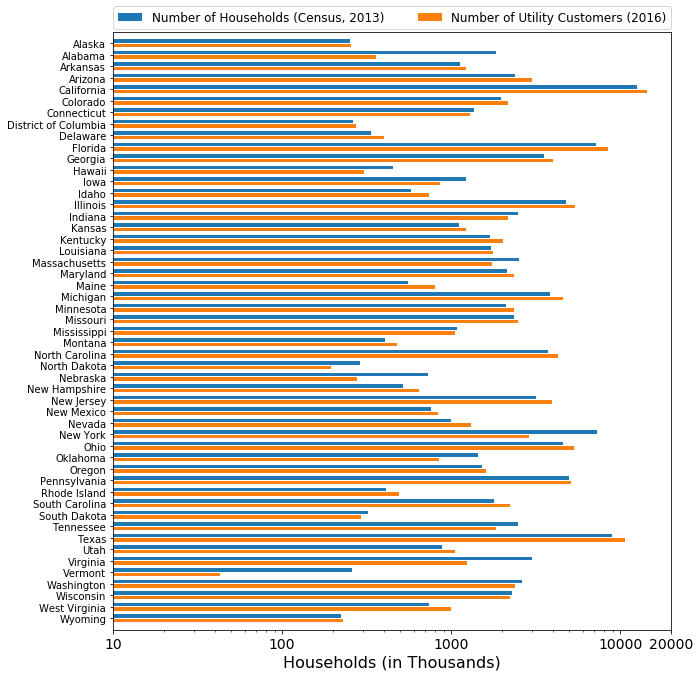

In [399]:
pylab.rcParams['figure.figsize'] = (10.0, 11.0)
plt.figure()
y_pos1 = np.arange(len(stateDict['State']))
plt.barh(y_pos1-0.2, stateDict['Households'], height=0.3, align='center', label='Number of Households (Census, 2013)')
plt.barh(y_pos1+0.2, stateDict['TotalCustomers'], height=0.3, align='center', label='Number of Utility Customers (2016)')
plt.yticks(y_pos1,stateDict['State'])
plt.ylim(len(stateDict['State']),-1)  # labels read top-to-bottom
plt.xlim(10000,2e7)
plt.xscale('log')
plt.xticks([1e4,1e5,1e6,1e7,2e7],\
           [10,100,1000,10000,20000],fontsize=14)
plt.xlabel('Households (in Thousands)',fontsize=16)
plt.legend(bbox_to_anchor=(0., 1.005 , 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0. ,fontsize=12)

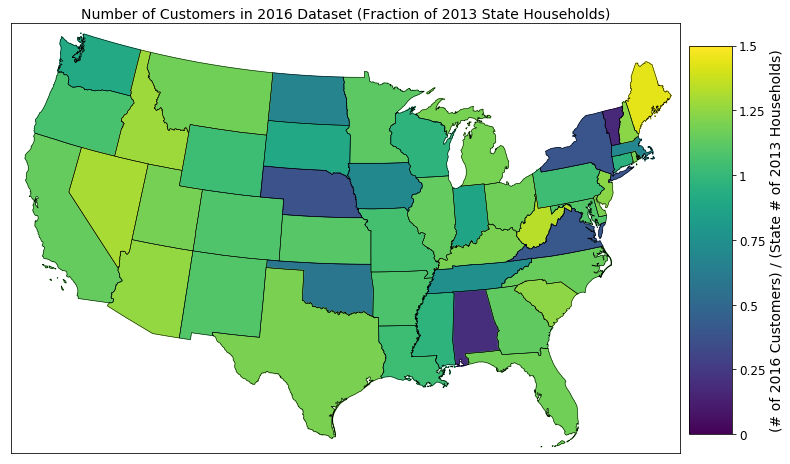

In [400]:
pylab.rcParams['figure.figsize'] = (12.0, 9.0)

m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.readshapefile('/Users/ekpease/Downloads/cb_2017_us_state_5m/cb_2017_us_state_5m', name='states', drawbounds=True)
ax = plt.gca() # get current axes instance
fig = plt.gcf()    
for nshape,seg in enumerate(m.states):
    # skip DC and Puerto Rico.
    if statenames[nshape] in stateDict['State']:
        color = rgb2hex(stateDict['map_color_frac'][stateDict['State']==statenames[nshape]].ravel()) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.title('Number of Customers in 2016 Dataset (Fraction of 2013 State Households)',fontsize=14)
cax = fig.add_axes([0.91, 0.2, 0.05, 0.6]) # posititon
cb = ColorbarBase(cax,cmap=cmap,orientation='vertical')
cb.set_label('(# of 2016 Customers) / (State # of 2013 Households)',fontsize=14)
cb.set_ticks([0,0.167,0.333,0.5,0.667,0.833,1])
cb.set_ticklabels(['0','0.25','0.5','0.75','1','1.25','1.5'])
cb.ax.tick_params(labelsize=12)
plt.show()

This suggests that state-wide averages for different reliability indices in this dataset may not accurately represent the experience of the average household in Alabama, Vermont, Nebraska, Virginia, and New York. Otherwise, the dataset appears to contain information on utilities that cover more than 50% of the households in each state.

A couple definitions for reliability indices included in this dataset:

SAIDI: System Average Interruption Duration Index, or the total outage time on average for customers that year (reported in minutes in this dataset)

SAIFI: System Average Interruption Frequency Index, or the average number of outages for customers that year

Let's first look at the outage durations (SAIDI) for customers in the 50 states. Below I plot the average SAIDI values for utilities in each state, weighting the average by the number of customers in each utility.

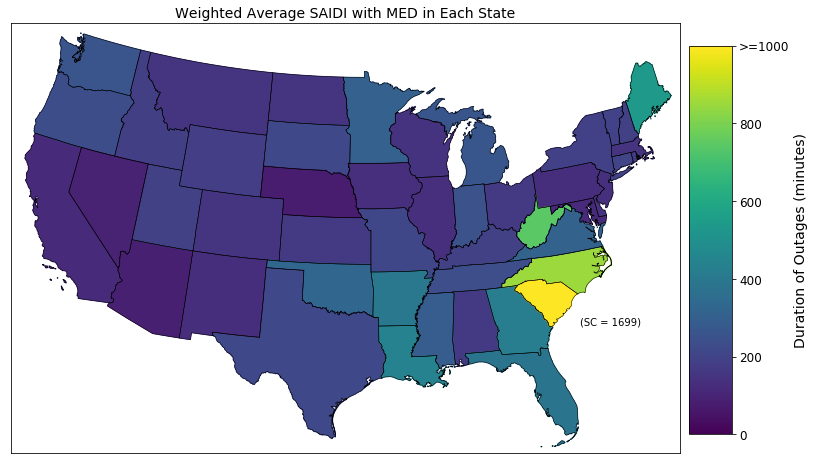

In [401]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.readshapefile('/Users/ekpease/Downloads/cb_2017_us_state_5m/cb_2017_us_state_5m', name='states', drawbounds=True)
ax = plt.gca() # get current axes instance
fig = plt.gcf()    
for nshape,seg in enumerate(m.states):
    if statenames[nshape] in stateDict['State']:
        color = rgb2hex(stateDict['map_color_SAIDI'][stateDict['State']==statenames[nshape]].ravel()) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.annotate('(SC = 1699)', xy=(0.85, 0.3), xycoords='axes fraction')
plt.title('Weighted Average SAIDI with MED in Each State',fontsize=14)
cax = fig.add_axes([0.91, 0.2, 0.05, 0.6]) # posititon
cb = ColorbarBase(cax,cmap=cmap,orientation='vertical')
cb.set_label('Duration of Outages (minutes)',fontsize=14)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
# maxSAIDI=np.round(max(stateDict['avgSAIDI']),decimals=-1)
maxSAIDI=1000
cb.set_ticklabels(['0',str(int(0.2*maxSAIDI)),str(int(0.4*maxSAIDI)),str(int(0.6*maxSAIDI)),\
                   str(int(0.8*maxSAIDI)),'>='+str(int(maxSAIDI))])
cb.ax.tick_params(labelsize=12)
plt.show()

In 2016, Tropical Storm Bonnie and Hurricanes Hermine and Matthew caused widespread electricity outages and billions of dollars of damage in the Southeast, especially in the Carolinas. This helps to explain the large outage durations shown for NC and SC in the plot above.

Fortunately, the dataset includes reliability data with "Major Event Days" (MED) excluded as well. "Major Events" are defined as events that exceed design and/or operational limits of the system, and they should remove the outages due to the extreme weather from the calculations of the yearly average values (referred to as SAIDI (SAIFI) without MED).

The same plot as above is made below with the "SAIDI without MED" data used instead.

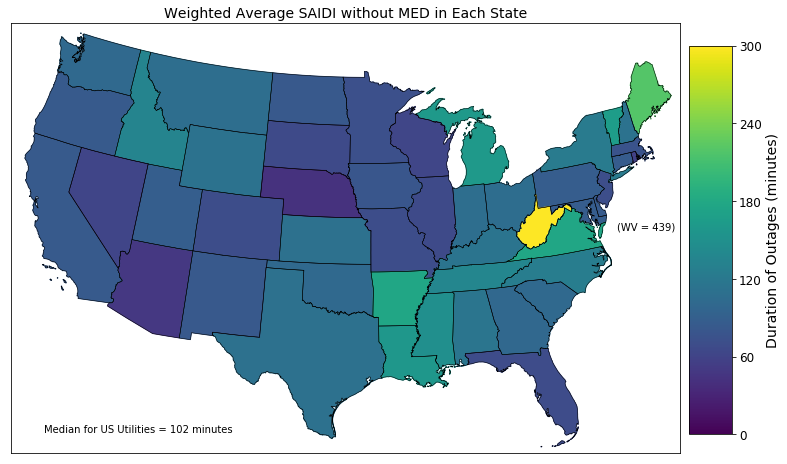

In [408]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.readshapefile('/Users/ekpease/Downloads/cb_2017_us_state_5m/cb_2017_us_state_5m', name='states', drawbounds=True)
ax = plt.gca() # get current axes instance
fig = plt.gcf()    
for nshape,seg in enumerate(m.states):
    if statenames[nshape] in stateDict['State']:
        color = rgb2hex(stateDict['map_color_SAIDI_noMED'][stateDict['State']==statenames[nshape]].ravel()) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.annotate('Median for US Utilities = '+str(int(np.round(np.median(utilDict['SAIDI_noMED'][(utilDict['SAIDI_noMED']>=0)].astype(float)),decimals=0)))+' minutes', xy=(0.05, 0.05), xycoords='axes fraction')
plt.annotate('(WV = 439)', xy=(0.905, 0.52), xycoords='axes fraction')
plt.title('Weighted Average SAIDI without MED in Each State',fontsize=14)
cax = fig.add_axes([0.91, 0.2, 0.05, 0.6]) # posititon
cb = ColorbarBase(cax,cmap=cmap,orientation='vertical')
cb.set_label('Duration of Outages (minutes)',fontsize=14)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
# maxSAIDI=np.round(max(stateDict['avgSAIDI']),decimals=-1)
maxSAIDI=360
cb.set_ticklabels(['0',str(int(maxSAIDI/6)),str(int(maxSAIDI/3)),str(int(maxSAIDI/2)),\
                   str(int(2*maxSAIDI/3)),str(int(5*maxSAIDI/6)),'>='+str(int(maxSAIDI))])
cb.ax.tick_params(labelsize=12)
plt.show()

Nearly all the state averages are within ~30 minutes of the median SAIDI value for US utilities.

This suggests that West Virginia's utilities had an especially rough year in 2016, with the average power customer experiencing more than 7 hours of outage time during the year (more than 4x the US utilities' median).

The same plot is shown below with "SAIFI without MED" values.

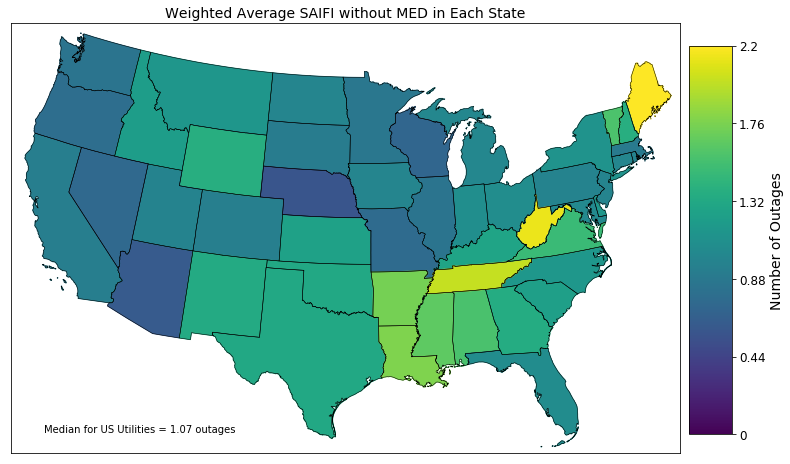

In [410]:
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=33,lat_2=45,lon_0=-95)
m.readshapefile('/Users/ekpease/Downloads/cb_2017_us_state_5m/cb_2017_us_state_5m', name='states', drawbounds=True)
ax = plt.gca() # get current axes instance
fig = plt.gcf()    
for nshape,seg in enumerate(m.states):
    if statenames[nshape] in stateDict['State']:
        color = rgb2hex(stateDict['map_color_SAIFI_noMED'][stateDict['State']==statenames[nshape]].ravel()) 
        poly = Polygon(seg,facecolor=color,edgecolor=color)
        ax.add_patch(poly)
plt.annotate('Median for US Utilities = '+str(np.round(np.median(utilDict['SAIFI_noMED'][(utilDict['SAIFI_noMED']>=0)].astype(float)),decimals=2))+' outages', xy=(0.05, 0.05), xycoords='axes fraction')
plt.title('Weighted Average SAIFI without MED in Each State',fontsize=14)
cax = fig.add_axes([0.91, 0.2, 0.05, 0.6]) # posititon
cb = ColorbarBase(cax,cmap=cmap,orientation='vertical')
cb.set_label('Number of Outages',fontsize=14)
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
maxSAIFI=np.round(max(stateDict['avgSAIFI_noMED']),decimals=1)
cb.set_ticklabels(['0',str(0.2*maxSAIFI),str(0.4*maxSAIFI),str(0.6*maxSAIFI),str(0.8*maxSAIFI),str(maxSAIFI)])
cb.ax.tick_params(labelsize=12)
plt.show()

The average number of outages for customers in each of the states was under 2, with the exception of Maine (2.16) and West Virginia (2.10).

Which type of Utility is the most reliable? Well, we have the SAIDI and SAIFI indices from IEEE to help answer this question, but I'm also going to invent my own Reliability Score that is a function these two indices.

In [424]:
# Come up with a reliability score to create a ranking of utilities (Power Rankings, if you will)
# Zero == Best Possible Score

def RelScore(SAIFI, SAIDI):
    return (1.5*SAIFI**2 + (SAIDI/60))

# Example interpretation:  a utility with SAIFI = 1 and SAIDI = 600 minutes is considered as reliable as
#                          another with SAIFI = 2 and SAIDI = 330
# Trying to penalize more harshly for additional outages. In my mind, a second short outage is worse
# than one longer single outage - this is just a quick and dirty stab at it, but it could be better
# designed with, for example, info on money/productivity lost as a function of outage duration

def plotRelScore(scoreVal,minY=2):
    SAIFI = linspace(0,5,100000)
    SAIDI = 60*(scoreVal-1.5*SAIFI**2)
    plt.plot(SAIFI[(SAIDI>minY) & (SAIDI<10000)],SAIDI[(SAIDI>minY) & (SAIDI<10000)],'-.m',alpha=0.5)

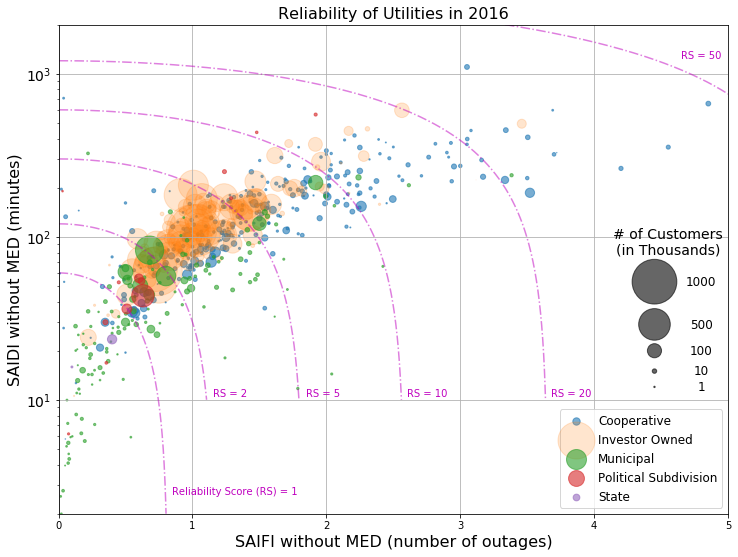

In [427]:
pylab.rcParams['figure.figsize'] = (12.0, 9.0)

plt.figure()
plt.xlim(0,5); plt.ylim(2,2*10**3);
plt.yscale('log'); #plt.xticks([2,3,4,5,6,7],['10$^2$','10$^3$','10$^4$','10$^5$','10$^6$','10$^7$'],fontsize=14);
plt.yticks(fontsize=14); plt.grid();
plotRelScore(1); plotRelScore(2,minY=10); plotRelScore(5,minY=10);\
plotRelScore(10,minY=10); plotRelScore(20,minY=10); plotRelScore(50);
plt.annotate('Reliability Score (RS) = 1', xy=(0.17, 0.04), color='m', xycoords='axes fraction')
plt.annotate('RS = 2', xy=(0.23, 0.24), color='m', xycoords='axes fraction')
plt.annotate('RS = 5', xy=(0.37, 0.24), color='m', xycoords='axes fraction')
plt.annotate('RS = 10', xy=(0.52, 0.24), color='m', xycoords='axes fraction')
plt.annotate('RS = 20', xy=(0.735, 0.24), color='m', xycoords='axes fraction')
plt.annotate('RS = 50', xy=(0.93, 0.93), color='m', xycoords='axes fraction')
for iterType in np.unique(utilDict['Type']):
    if iterType=='Investor Owned':
        alphaPlt = 0.2
    else:
        alphaPlt = 0.6
    x= utilDict['SAIFI_noMED'][(utilDict['Type']==iterType) & (utilDict['SAIDI_noMED']>=0) & (utilDict['SAIFI_noMED']>=0)].astype(float)
    y= utilDict['SAIDI_noMED'][(utilDict['Type']==iterType) & (utilDict['SAIDI_noMED']>=0) & (utilDict['SAIFI_noMED']>=0)].astype(float)
    s_plt= (1/500)*(utilDict['Customers'][(utilDict['Type']==iterType) & (utilDict['SAIDI_noMED']>=0) & (utilDict['SAIFI_noMED']>=0)].astype(float))
    plt.scatter(x,y,s=s_plt,marker ='.',alpha=alphaPlt,label=iterType)
    
plt.scatter(4.45*np.ones(5),[12,15,20,29,53],s=[2, 20, 200, 1000, 2000],c='k',alpha=0.6)
plt.text(4.8,12,'1',horizontalalignment='center',verticalalignment='center',fontsize=12)
plt.text(4.8,15,'10',horizontalalignment='center',verticalalignment='center',fontsize=12)
plt.text(4.8,20,'100',horizontalalignment='center',verticalalignment='center',fontsize=12)
plt.text(4.8,29,'500',horizontalalignment='center',verticalalignment='center',fontsize=12)
plt.text(4.8,53,'1000',horizontalalignment='center',verticalalignment='center',fontsize=12)
plt.text(4.55,75,'# of Customers\n(in Thousands)',horizontalalignment='center',verticalalignment='bottom',fontsize=14)
plt.legend(fontsize=12,loc='lower right');
plt.ylabel('SAIDI without MED (minutes)',fontsize=16);
plt.xlabel('SAIFI without MED (number of outages)',fontsize=16);
plt.title('Reliability of Utilities in 2016',fontsize=16)

Note that, in addition to the reliability data, information on utility size and type has also been incorporated.

The largest utilities are typically investor-owned. The investor-owned utilities appear to densely populate the region of this plot where the median reliability index values are [(SAIFI, SAIDI) = (1.07, 102)]. Municipal and cooperative utilities each appear to serve approximately the same number of customers (with a few larger exceptions in the case of Municipals), but Municipals have noticeably fewer and shorter outages than Cooperatives. Naively, this makes sense as Municipals are likely in individual towns and cities (more tightly bunched; shorter response times and less equipment/transmission line length needed per customer), while Cooperatives may also include possibly geographically larger and  more rural households.

Let's see how the different utility types rate in terms of my Reliability Score...

In [429]:
utilDict['RelScore'] = RelScore(utilDict['SAIFI'],utilDict['SAIDI'])
utilDict['RelScore'][((utilDict['SAIFI']<0) | (utilDict['SAIDI']<0))] = -99
utilDict['RelScore_noMED'] = RelScore(utilDict['SAIFI_noMED'],utilDict['SAIDI_noMED'])
utilDict['RelScore_noMED'][((utilDict['SAIFI_noMED']<0) | (utilDict['SAIDI_noMED']<0))] = -99
utilDict['RelScore'] = np.asarray(utilDict['RelScore'])
utilDict['RelScore'] = utilDict['RelScore'].astype(float)
utilDict['RelScore_noMED'] = np.asarray(utilDict['RelScore_noMED'])
utilDict['RelScore_noMED'] = utilDict['RelScore_noMED'].astype(float)

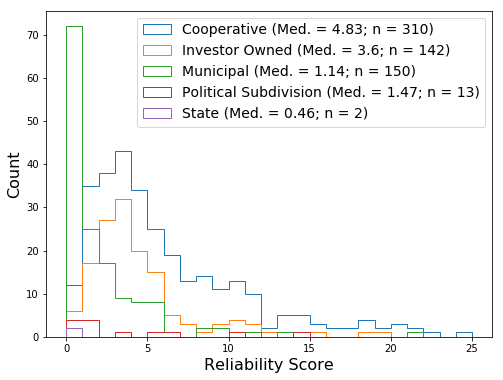

In [430]:
pylab.rcParams['figure.figsize'] = (8.0, 6.0)

plt.figure()
for iterType in np.unique(utilDict['Type']):
    x = utilDict['RelScore_noMED'][(utilDict['Type']==iterType) & (utilDict['SAIDI_noMED']>=0) & (utilDict['SAIFI_noMED']>=0)]
    plt.hist(x,25,[0,25],histtype='step',\
             label=iterType+' (Med. = '+str(np.round(np.median(x),decimals=2))+'; n = '+str(int(len(x)))+')')
plt.legend(fontsize=14,loc='upper right');
plt.xlabel('Reliability Score',fontsize=16);
plt.ylabel('Count',fontsize=16);

Using the Reliability Score, let's rank utility companies in the US and in individual states. This could be a valuable tool for state and local governments, people who are contemplating which part of a state to move to, or the utility companies themselves.

In [445]:
def RankUtilities(num=5,state='all',inclMED=False,worst=False):
    # Returns a list of the top or bottom 'num' utility companies in order of their Reliability Score
    if inclMED==True:
        states = utilDict['State'][utilDict['RelScore']>=0]
        names = utilDict['Name'][utilDict['RelScore']>=0]
        scores = utilDict['RelScore'][utilDict['RelScore']>=0]
        SAIFI = utilDict['SAIFI'][utilDict['RelScore']>=0]
        SAIDI = utilDict['SAIDI'][utilDict['RelScore']>=0]
    else:
        states = utilDict['State'][utilDict['RelScore_noMED']>=0]
        names = utilDict['Name'][utilDict['RelScore_noMED']>=0]
        scores = utilDict['RelScore_noMED'][utilDict['RelScore_noMED']>=0]
        SAIFI = utilDict['SAIFI_noMED'][utilDict['RelScore_noMED']>=0]
        SAIDI = utilDict['SAIDI_noMED'][utilDict['RelScore_noMED']>=0]
    
    if state=='all':
        tupled = zip(states,names,scores,SAIFI,SAIDI)
        ranked = sorted(tupled, key=lambda util: util[2])
        if worst==False:
            print('Top '+str(num)+' in the US in 2016')
            for ii in range(num):
                print(str(ii+1) + '. ' + ranked[ii][1] + ', (' + ranked[ii][0] + '): ' + str(ranked[ii][2]))
        else:
            print('Bottom '+str(num)+' in the US in 2016')
            for ii in range(num):
                print(str(ii+1) + '. ' + ranked[-(ii+1)][1] + ', (' + ranked[-(ii+1)][0] + '): ' + str(ranked[-(ii+1)][2]))
    else:
        tupled = zip(states[states==state],names[states==state],scores[states==state],\
                     SAIFI[states==state],SAIDI[states==state])
        ranked = sorted(tupled, key=lambda util: util[2])
        if worst==False:
            print('Top '+str(num)+' in '+state+' in 2016')
            if num < len(states[states==state]):
                for ii in range(num):
                    print(str(ii+1) + '. ' + ranked[ii][1] + ': ' + str(ranked[ii][2]))
            else:
                for ii in range(len(states[states==state])):
                    print(str(ii+1) + '. ' + ranked[ii][1] + ': ' + str(ranked[ii][2]))
        else:
            print('Bottom '+str(num)+' in '+state+' in 2016')
            if num < len(states[states==state]):
                for ii in range(num):
                    print(str(ii+1) + '. ' + ranked[-(ii+1)][1] + ': ' + str(ranked[-(ii+1)][2]))
            else:
                for ii in range(len(states[states==state])):
                    print(str(ii+1) + '. ' + ranked[-(ii+1)][1] + ': ' + str(ranked[-(ii+1)][2]))
    print('\n')
            

In [446]:
RankUtilities(num=10)
RankUtilities(state='California')
RankUtilities(state='West Virginia')

Top 10 in the US in 2016
1. City Utilities of Springfield - (MO), (Missouri): 0.0
2. Two Rivers Water & Light, (Wisconsin): 0.0
3. UNS Electric, Inc, (Arizona): 0.0
4. Bristol Virginia Utilities, (Virginia): 0.00419683333333
5. Lawrenceburg Municipal Utils, (Indiana): 0.00475733333333
6. Conway Corporation, (Arkansas): 0.005274
7. City of Independence - (IA), (Iowa): 0.0168093333333
8. City of Sauk Centre - (MN), (Minnesota): 0.0258673333333
9. City of Tipp City - (OH), (Ohio): 0.0293375
10. Hurricane City Power, (Utah): 0.0339948333333


Top 5 in California in 2016
1. City of Pasadena - (CA): 0.30165
2. City of Alameda: 0.40665
3. City of Azusa: 0.816296833333
4. City of Palo Alto - (CA): 0.85075
5. Anza Electric Coop Inc: 0.9930215


Top 5 in West Virginia in 2016
1. The Potomac Edison Company: 4.45212266667
2. Monongahela Power Co: 11.6598193333
3. Wheeling Power Co: 15.6283735
4. Appalachian Power Co: 19.7994773333
5. Craig-Botetourt Electric Coop: 26.2222666667




In [447]:
RankUtilities(state='California',worst=True)

Bottom 5 in California in 2016
1. Truckee Donner P U D: 10.5614333333
2. Liberty Utilities: 5.86247733333
3. PacifiCorp: 5.45856683333
4. Pacific Gas & Electric Co: 3.3786615
5. Southern California Edison Co: 3.31502066667




Try to control for state-by-state variation by looking at SAIDI and SAIFI of individual utilities relative to their state's average

In [440]:
utilDict['SAIDI_rel'] = -99999.0*np.ones_like(utilDict['SAIDI'].astype(float))
utilDict['SAIFI_rel'] = -99999.0*np.ones_like(utilDict['SAIFI'].astype(float))
utilDict['SAIDI_noMED_rel'] = -99999.0*np.ones_like(utilDict['SAIDI_noMED'].astype(float))
utilDict['SAIFI_noMED_rel'] = -99999.0*np.ones_like(utilDict['SAIFI_noMED'].astype(float))
for stateIter in stateDict['State']:
    utilDict['SAIDI_rel'][utilDict['State']==stateIter] = (utilDict['SAIDI'][utilDict['State']==stateIter].astype(float))/(stateDict['avgSAIDI'][stateDict['State']==stateIter])
    utilDict['SAIFI_rel'][utilDict['State']==stateIter] = (utilDict['SAIFI'][utilDict['State']==stateIter].astype(float))/(stateDict['avgSAIFI'][stateDict['State']==stateIter])
    utilDict['SAIDI_noMED_rel'][utilDict['State']==stateIter] = (utilDict['SAIDI_noMED'][utilDict['State']==stateIter].astype(float))/(stateDict['avgSAIDI_noMED'][stateDict['State']==stateIter])
    utilDict['SAIFI_noMED_rel'][utilDict['State']==stateIter] = (utilDict['SAIFI_noMED'][utilDict['State']==stateIter].astype(float))/(stateDict['avgSAIFI_noMED'][stateDict['State']==stateIter])

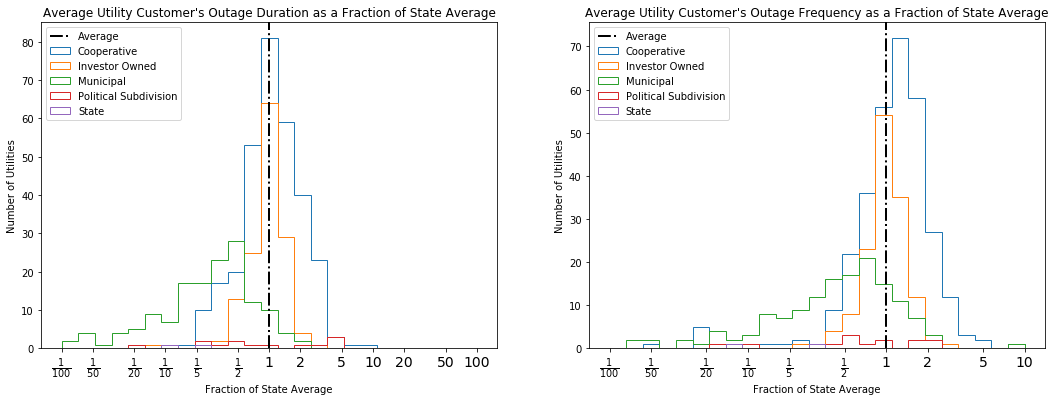

In [441]:
pylab.rcParams['figure.figsize'] = (18.0, 6.0)
plt.figure()
plt.subplot(1,2,1)
for iterType in np.unique(utilDict['Type']):
    plt.hist(np.log10(utilDict['SAIDI_noMED_rel'][(utilDict['Type']==iterType) & (utilDict['SAIDI_noMED']>0) & (utilDict['SAIFI_noMED']>=0)].astype(float)),\
             25,[-2,2],histtype='step',label=iterType)
ylim = plt.ylim()
plt.plot([0,0],ylim,'-.k',linewidth=2,label='Average')
plt.ylim(ylim)
plt.legend(loc='upper left')
plt.ylabel('Number of Utilities'); plt.xlabel('Fraction of State Average')
plt.xticks([-2,np.log10(0.02),np.log10(0.05),-1,np.log10(0.2),np.log10(0.5),0,np.log10(2),np.log10(5),1,np.log10(20),np.log10(50),2],\
           [r'$\frac{1}{100}$',r'$\frac{1}{50}$',r'$\frac{1}{20}$',r'$\frac{1}{10}$',r'$\frac{1}{5}$',r'$\frac{1}{2}$','1','2','5','10','20','50','100'],fontsize=14);
plt.title('Average Utility Customer\'s Outage Duration as a Fraction of State Average')
plt.subplot(1,2,2)
for iterType in np.unique(utilDict['Type']):
    plt.hist(np.log10(utilDict['SAIFI_noMED_rel'][(utilDict['Type']==iterType) & (utilDict['SAIDI_noMED']>=0) & (utilDict['SAIFI_noMED']>0)].astype(float)),\
             25,[-2,1],histtype='step',label=iterType)
ylim = plt.ylim()
plt.plot([0,0],ylim,'-.k',linewidth=2,label='Average')
plt.ylim(ylim)
plt.legend(loc='upper left')
plt.ylabel('Number of Utilities'); plt.xlabel('Fraction of State Average')
plt.xticks([-2,np.log10(0.02),np.log10(0.05),-1,np.log10(0.2),np.log10(0.5),0,np.log10(2),np.log10(5),1],\
           [r'$\frac{1}{100}$',r'$\frac{1}{50}$',r'$\frac{1}{20}$',r'$\frac{1}{10}$',r'$\frac{1}{5}$',r'$\frac{1}{2}$','1','2','5','10'],fontsize=14);
plt.title('Average Utility Customer\'s Outage Frequency as a Fraction of State Average')


In [ ]:
stateDict['avgRS'] = []
stateDict['avgRS_noMED'] = []
for stateXX in np.unique(utilities_basicinfo[:,0]):
    stateDict['avgRS'].append(sum((utilDict['Customers']*utilDict['RelScore'])[(utilDict['State']==short_state_names[stateXX]) & (utilDict['RelScore']>=0)])/sum(utilDict['Customers'][(utilDict['State']==short_state_names[stateXX]) & (utilDict['RelScore']>=0)]))
    stateDict['avgRS_noMED'].append(sum((utilDict['Customers']*utilDict['RelScore_noMED'])[(utilDict['State']==short_state_names[stateXX]) & (utilDict['RelScore_noMED']>=0)])/sum(utilDict['Customers'][(utilDict['State']==short_state_names[stateXX]) & (utilDict['RelScore_noMED']>=0)]))
    
stateDict['avgRS'] = np.asarray(stateDict['avgRS'])
stateDict['avgRS_noMED'] = np.asarray(stateDict['avgRS_noMED'])